In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2
import numpy as np
from collections import deque

In [2]:
# Load calibration data
_npzfile=np.load('calibration_params.npz')
dist=_npzfile['dist']
mtx=_npzfile['mtx']
# Load Perspective Maps
_pmapfile=np.load('perspective_maps.npz')
M=_pmapfile['M']
Minv=_pmapfile['Minv']

In [3]:
# Swap the array/tuple elements
quick_swap=lambda x:(x[1],x[0])

In [4]:
# Function to apply Soble - Lecture/Quiz outputs
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output


In [5]:
def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output


In [6]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


In [7]:
def hls_threshold(img,thresh=(0,255)):
    hls=cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    s_channel=hls[:,:,2]
    s_bin=np.zeros_like(s_channel)
    s_bin[(s_channel>=thresh[0])&(s_channel<=thresh[1])] = 1
    return s_bin


In [8]:
def combine_bin_images(img1,img2):
#     Or operation b/n images
    combined_binary = np.zeros_like(img1)
    combined_binary[(img1 == 1) | (img2 == 1)] = 1
    return combined_binary


In [9]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line (n=10)
        self.recent_xfitted = deque(maxlen=10)
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [10]:
# Declare left and right lines:
left = Line()
right= Line()


In [11]:
# Parameters:
ksize=11
gradx_thresh=(30, 110)
grady_thresh=(50, 250)
mag_thresh=(50, 150)
dir_thresh=(0.5, 1.2)
hls_thresh=(170,255)
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Sliding window parameters
sldwin_nwindows = 9 #number of sliding windows
sldwin_margin = 100 #width of the windows +/- margin
sldwin_minpx = 50 #minimum number of pixels to recenter window

In [12]:
def get_lane_lines(binary_warped,left,right):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = sldwin_nwindows
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = sldwin_margin
    if left.detected == False or right.detected == False:
        # Set minimum number of pixels found to recenter window
        minpix = sldwin_minpx
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []    
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        left.detected=True
        right.detected=True
    else:
        left_lane_inds = ((nonzerox > (left.current_fit[0]*(nonzeroy**2) + left.current_fit[1]*nonzeroy + left.current_fit[2] - margin)) & (nonzerox < (left.current_fit[0]*(nonzeroy**2) + left.current_fit[1]*nonzeroy + left.current_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right.current_fit[0]*(nonzeroy**2) + right.current_fit[1]*nonzeroy + right.current_fit[2] - margin)) & (nonzerox < (right.current_fit[0]*(nonzeroy**2) + right.current_fit[1]*nonzeroy + right.current_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left.current_fit = left_fit = np.polyfit(lefty, leftx, 2)
    right.current_fit = right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    left.ally= right.ally = ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left.allx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right.allx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left.recent_xfitted.append(left.allx)
    right.recent_xfitted.append(right.allx)
    
    left.bestx = np.average(left.recent_xfitted,axis=0)
    right.bestx = np.average(right.recent_xfitted, axis=0)
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(left.ally)
    left.radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right.radius_of_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Measure distance from center of image:
    left.line_base_pos = (binary_warped.shape[1]/2 - left.bestx[-1])*xm_per_pix
    right.line_base_pos = (right.bestx[-1] - binary_warped.shape[1]/2)*xm_per_pix
    
    

In [13]:
def reproject_lines(undist,left,right,Minv):
    color_warp=np.zeros_like(undist).astype(np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left.bestx, left.ally]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right.bestx, right.ally])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    av_radius=np.max(left.radius_of_curvature+right.radius_of_curvature)
    rad_text="Curvature (l,r): ({:.2f}m,{:.2f})".format(left.radius_of_curvature,right.radius_of_curvature)
    off_text = "Vehicle offset {:.2f}m".format(left.line_base_pos-right.line_base_pos)
    cv2.putText(result,rad_text, (50,80), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255),3)
    cv2.putText(result,off_text, (50,160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255),3)
    return result

In [14]:
def main_process(image):
# # Steps:
#     1. Read the frame - frame is RGB input
#     2. undistort image
    undist=cv2.undistort(image,mtx,dist,None,mtx)
#     3. Color & Gradient Thresholding
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=gradx_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=grady_thresh)
    mag_binary = mag_threshold(image, sobel_kernel=ksize, thresh=mag_thresh)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=dir_thresh)
    grad_mag_combined = np.zeros_like(dir_binary)
    grad_mag_combined[((gradx==1)&(grady==1))|((mag_binary==1)&(dir_binary==1))] = 1
    hls_binary=hls_threshold(image,thresh=hls_thresh)
    combined=combine_bin_images(hls_binary,grad_mag_combined)
#     4. Warp the image (Perspective Transform)
    warped=cv2.warpPerspective(combined,M,dsize=quick_swap(image.shape[:2]))
# 5. Determing Lane
    get_lane_lines(warped,left,right)
# 6. Reproject the line and return the frame
    new_frame=reproject_lines(undist,left,right,Minv)
    return new_frame

    

In [15]:
image=cv2.cvtColor(cv2.imread('../test_images/test3.jpg'), cv2.COLOR_BGR2RGB)
x=main_process(image)

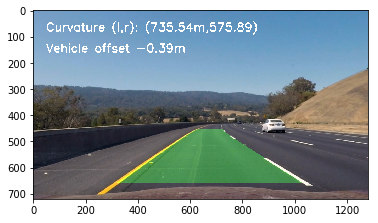

In [16]:
plt.imshow(x)

In [17]:
# Test on video:
from moviepy.editor import VideoFileClip
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(main_process)
out_file="submission.mp4"
%time white_clip.write_videofile(out_file, audio=False)

[MoviePy] >>>> Building video submission.mp4
[MoviePy] Writing video submission.mp4


100%|█████████▉| 1260/1261 [05:42<00:00,  3.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: submission.mp4 

CPU times: user 19min 21s, sys: 7.57 s, total: 19min 28s
Wall time: 5min 42s


In [18]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_file))

Video - 1 
 took 19m; jarry lines;